In [106]:
import dicom
import os
import numpy
from matplotlib import pyplot, cm
from matplotlib import pylab
from sklearn import datasets, neighbors, linear_model
from skimage.feature import greycomatrix, greycoprops

In [107]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = numpy.random.permutation(len(a))
    return a[p], b[p]

In [145]:
pathTrainNeg = "./fibrosis_patches_8/train/norm"
pathTrainPos = "./fibrosis_patches_8/train/path"
pathTestPos = "./fibrosis_patches_8/test/path"
pathTestNeg = "./fibrosis_patches_8/test/norm"
lstFilesTrainNeg = []
lstFilesTrainPos = []
lstFilesTestNeg = []
lstFilesTestPos = []
for dirName, subdirList, fileList in os.walk(pathTrainNeg):
    for filename in fileList:
        if ".dcm" in filename.lower():
            lstFilesTrainNeg.append(os.path.join(dirName,filename))
for dirName, subdirList, fileList in os.walk(pathTrainPos):
    for filename in fileList:
        if ".dcm" in filename.lower():
            lstFilesTrainPos.append(os.path.join(dirName,filename))
for dirName, subdirList, fileList in os.walk(pathTestPos):
    for filename in fileList:
        if ".dcm" in filename.lower():
            lstFilesTestPos.append(os.path.join(dirName,filename))
for dirName, subdirList, fileList in os.walk(pathTestNeg):
    for filename in fileList:
        if ".dcm" in filename.lower():
            lstFilesTestNeg.append(os.path.join(dirName,filename))

In [146]:
pos_train=[]
neg_train=[]
X_train=[]
y_train=[]
X_test=[]
y_test=[]
learn_num = 2000

for idx,img in enumerate(lstFilesTrainNeg):
    #temp = numpy.ravel(dicom.read_file(img).pixel_array)
    temp = dicom.read_file(img).pixel_array
    matrix=[]
    for t in temp:
        matrix_line=[]
        for val in t:
            matrix_line.append((int)(256*val/7000))
        matrix.append(matrix_line)
    X_train.append(matrix)
    neg_train.append(matrix)
    y_train.append(0)
    if idx>learn_num:
        break

for idx,img in enumerate(lstFilesTrainPos):
    #temp = numpy.ravel(dicom.read_file(img).pixel_array)
    temp = dicom.read_file(img).pixel_array
    matrix=[]
    for t in temp:
        matrix_line=[]
        for val in t:
            matrix_line.append((int)(256*val/7000))
        matrix.append(matrix_line)
    X_train.append(matrix)
    pos_train.append(matrix)
    y_train.append(1)
    if idx>learn_num:
        break

(X_train, y_train) = unison_shuffled_copies(numpy.asarray(X_train), numpy.asarray(y_train))
for idx,img in enumerate(lstFilesTestNeg):
    #temp = numpy.ravel(dicom.read_file(img).pixel_array)
    temp = dicom.read_file(img).pixel_array
    matrix=[]
    for t in temp:
        matrix_line=[]
        for val in t:
            matrix_line.append((int)(256*val/7000))
        matrix.append(matrix_line)
    X_test.append(matrix)
    y_test.append(0)
    if idx>learn_num:
        break
for idx,img in enumerate(lstFilesTestPos):
    #temp = numpy.ravel(dicom.read_file(img).pixel_array)
    temp = dicom.read_file(img).pixel_array
    matrix=[]
    for t in temp:
        matrix_line=[]
        for val in t:
            matrix_line.append((int)(256*val/7000))
        matrix.append(matrix_line)
    X_test.append(matrix)
    y_test.append(1)
    if idx>learn_num:
        break


In [147]:
GLCM_train =[]
GLCM_test =[]
for img in X_train:
    glcm = greycomatrix(img, [2], [0], 340, symmetric=True, normed=True)
    GLCM_train.append([greycoprops(glcm, 'dissimilarity')[0, 0],greycoprops(glcm, 'correlation')[0, 0],greycoprops(glcm, 'homogeneity')[0, 0],greycoprops(glcm, 'contrast')[0, 0]])
for img in X_test:
    glcm = greycomatrix(img, [2], [0], 340, symmetric=True, normed=True)
    GLCM_test.append([greycoprops(glcm, 'dissimilarity')[0, 0],greycoprops(glcm, 'correlation')[0, 0],greycoprops(glcm, 'homogeneity')[0, 0],greycoprops(glcm, 'contrast')[0, 0]])

(array([ 1878.,   124.,     0.,     0.]),
 array([  0.,   5.,  10.,  15.,  20.]),
 <a list of 4 Patch objects>)

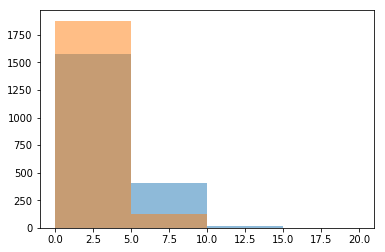

In [148]:
# plotting dissimilarity
%matplotlib inline
pos_list_x = [item[0] for idx,item in enumerate(GLCM_train) if y_train[idx]==1 ]
neg_list_x = [item[0] for idx,item in enumerate(GLCM_train) if y_train[idx]==0 ]
bins = numpy.linspace(0, 20, 5)
pyplot.hist(pos_list_x,bins,alpha=0.5)
pyplot.hist(neg_list_x,bins,alpha=0.5)

(array([ 2002.,     0.,     0.,     0.]),
 array([   0.,   25.,   50.,   75.,  100.]),
 <a list of 4 Patch objects>)

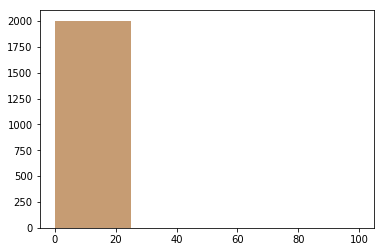

In [149]:
# plotting correlation
%matplotlib inline
pos_list_y = [item[1] for idx,item in enumerate(GLCM_train) if y_train[idx]==1 ]
neg_list_y = [item[1] for idx,item in enumerate(GLCM_train) if y_train[idx]==0 ]
bins = numpy.linspace(0, 100, 5)
pyplot.hist(pos_list_y,bins,alpha=0.5)
pyplot.hist(neg_list_y,bins,alpha=0.5)

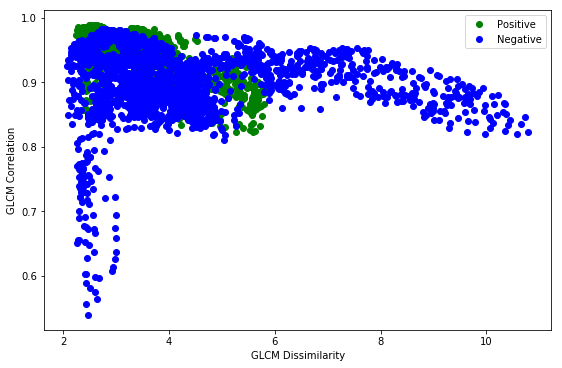

In [143]:
fig = pyplot.figure(figsize=(20, 20))
ax = fig.add_subplot(3, 2, 2)
ax.plot(pos_list_x, pos_list_y, 'go',
        label='Positive',alpha=0.5)
ax.plot(neg_list_x, neg_list_y, 'bo',
        label='Negative',alpha=0.5)
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

In [150]:
knn = neighbors.KNeighborsClassifier()
logistic = linear_model.LogisticRegression()

print('KNN score: %f' % knn.fit(GLCM_train, y_train).score(GLCM_test, y_test))
print('LogisticRegression score: %f'
      % logistic.fit(GLCM_train, y_train).score(GLCM_test, y_test))

KNN score: 0.489510
LogisticRegression score: 0.624376
